In [46]:
# !sudo apt-get install libtiff-dev

In [47]:
# 
is_on_colab = False

is_show_colab_env_info = False


if(is_on_colab):

    if(is_show_colab_env_info):

        
        def printm():

            process = psutil.Process(os.getpid())
            print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
            print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

        # memory footprint support libraries/code
        !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
        !pip install gputil
        !pip install psutil
        !pip install humanize  

        import psutil
        import humanize
        import os
        import GPUtil as GPU
        GPUs = GPU.getGPUs()
        # XXX: only one GPU on Colab and isn’t guaranteed
        gpu = GPUs[0]


        #GPU count and name
        !lscpu |grep 'Model name'
        !nvidia-smi -L
        printm()

  
    from google.colab import drive
    drive.mount('/content/drive')

    gdrive_home_dir = '/content/drive/My Drive/'

    project_dir = f'{gdrive_home_dir}DeepCNC/'
    ds_dir = f'{project_dir}data/'
    snapshot_dir = f'{project_dir}snapshots/'

    !ls '{ds_dir}'

else:
    project_dir = f'/disks/data/paper_projects/DeepCNC/'
    ds_dir = f'{project_dir}data/'
    snapshot_dir = f'{project_dir}snapshots/'


  

  

In [49]:
# embed = mk_model.vector('AAA')
# print(embed)
# type(embed)



from third_party.dna2vec_master.dna2vec.multi_k_model import MultiKModel


filepath = 'third_party/dna2vec_master/pretrained/dna2vec-20161219-0153-k3to8-100d-10c-29320Mbp-sliding-Xat.w2v'

mk_model = MultiKModel(filepath)




In [190]:
#12 Mar 2017
#In this file we are going to prepare data for CNN in different formats


from numpy import *
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import sys
import scipy.io as spio
import scipy
import os


from PIL import Image
from matplotlib import pyplot as plt 
import imageio
import skimage.io


def get_unique_labels(label_filename):
    with open(label_filename) as f:
        labels = [line.rstrip('\n') for line in f]
        
    return list(set(labels))

def get_save_img_func(ext):
    if(ext == 'npy'):
        save_as_image = lambda save_path, data: np.save(save_path+ '.npy', data )
        print('Will save images as numpy files')
    elif(ext == 'png'):
        def save_norm_params(save_path, a):
            min_per_ch = np.min(a, axis = (0,1))
            subd = a - min_per_ch[np.newaxis,np.newaxis,:]
            min_per_ch_subd = np.min(subd, axis = (0,1))
            max_per_ch_subd = np.max(subd, axis = (0,1))
            normed = subd/max_per_ch_subd[np.newaxis, np.newaxis, :]
            np.save(save_path + '_params.npy', np.array([min_per_ch,max_per_ch_subd]) )            
            return normed
            
        save_as_image = lambda save_path, data: scipy.misc.toimage(save_norm_params(save_path,data)).save(save_path + '.png')
        print('Will save images as png files')
    elif(ext == 'tif'):
        save_as_image = lambda save_path, data: skimage.io.imsave(save_path + '.tif', data)
        print('Will save images as tif files')
    else:
        raise NotImplementedError
        
    return save_as_image


def convert_seq_to_kmer_im(im_dims, seq, k_values):
    
    im_height, im_width, im_channel_count = im_dims

    kmer_img = np.zeros(shape = im_dims)
    
    for i in range(im_height):
        min_k_mer = seq[i:i + k_values[0]]
        min_k_p1_mer = seq[i:i + k_values[1]]
        min_k_p2_mer = seq[i:i + k_values[2]]

        min_k_mer_embedding = mk_model.vector(min_k_mer)

        min_k_p1_mer_embedding = mk_model.vector(min_k_p1_mer)                
        if(len(min_k_p1_mer) < k_values[1]):
            min_k_p1_mer_embedding = np.zeros_like(min_k_mer_embedding)

        min_k_p2_mer_embedding = mk_model.vector(min_k_p2_mer)
        if(len(min_k_p2_mer) < k_values[2]):
            min_k_p2_mer_embedding = np.zeros_like(min_k_mer_embedding)

        kmer_img[i,:,0] = min_k_mer_embedding
        kmer_img[i,:,1] = min_k_p1_mer_embedding
        kmer_img[i,:,2] = min_k_p2_mer_embedding

    return kmer_img


#In this function we are going to convert each sequence into image-like representation in 
#which each sequence will be represented as a matrix where the rows is the sequence and the
#columns are tri-nucleotides 
#------------- one-hot vector with 1 channel in 2D rep for Tri-nucleotides -------------
def save_seq_as_kmer_img(k_values, data_filename, label_filename, save_dir, seqLength, ext):
    
    valid_k_values = (3, 4, 5, 6, 7, 8)
    valid_extentions = ('npy', 'png', 'tif')
    
    if len(k_values)>3 or min(k_values)<3 or max(k_values)>8:
        print("-"*30)
        print("Only k = 3 to 8 are supported in groups of 3 ks")
        print("-"*30)
        raise NotImplementedError
    
    if ext not in valid_extentions:
        print("-"*30)
        print("Extension not supported")
        print("-"*30)
        raise NotImplementedError
            
    
    k_values.sort()
    min_k = min(k_values)
    embedding_len = len(mk_model.vector('AAA'))
    
    max_kmer_count = seqLength - min_k + 1    
    im_height = max_kmer_count
    im_width = embedding_len
    im_channel_count = len(k_values)
    im_dims = (im_height, im_width, im_channel_count)    
    
    with open(label_filename) as f:
        labels = [line.rstrip('\n') for line in f]
        
    save_img_func = get_save_img_func(ext)        
    
    with open(data_filename) as f:
        
        record_idx = 0
        
        for seq in f:
        
            seq = seq.strip()
            
            kmer_img = convert_seq_to_kmer_im(im_dims, seq, k_values)
            img_save_fname = save_dir+f'/{labels[record_idx]}/{record_idx}'
            save_img_func(img_save_fname, kmer_img)
            
            if((record_idx + 1)%500 == 0):
                print('written image count:',(record_idx+1))
                
            record_idx += 1
                

                

# Saves three K-mer embeddings of DNA sequences as an image

In [191]:
k_values = [3, 4, 5]
img_ext = 'tif' # tif saves the embeddings properly ( has > 1 and < 0 values) 
                # npy saves the embeddings properly as well 
                # png saves [0,1] normalized images with de-normalization parameters as metadata.

inputseq_filename = f'{ds_dir}inputSeq_N_ReplacedBy_C.txt';
inputlabel_filename = f'{ds_dir}inputLabel.txt'

with open(inputseq_filename) as f:
    sequence_length = len(f.readline().strip())
    

im_savedir = f'{ds_dir}imdata_'+"".join([str(k) for k in k_values])+'mer_' + img_ext + '/'

# get the list of labels
unique_labels = get_unique_labels(inputlabel_filename)

# make directories (indicating labels) for the images 
import os
_ = [os.makedirs(im_savedir+''+label, exist_ok = True) for label in unique_labels]


# convert DNA sequences to bitmap images and save in the directory under label subdirectory
save_seq_as_kmer_img( k_values = k_values,
                      data_filename = inputseq_filename, 
                      label_filename = inputlabel_filename, 
                      save_dir = im_savedir, 
                      seqLength = sequence_length, 
                      ext = img_ext )

Will save images as tif files
written image count: 500
written image count: 1000
written image count: 1500
written image count: 2000
written image count: 2500
written image count: 3000
written image count: 3500
written image count: 4000
written image count: 4500
written image count: 5000
written image count: 5500
written image count: 6000
written image count: 6500
written image count: 7000
written image count: 7500
written image count: 8000
written image count: 8500
written image count: 9000
written image count: 9500
written image count: 10000
written image count: 10500
written image count: 11000
written image count: 11500
written image count: 12000
written image count: 12500
written image count: 13000
written image count: 13500
written image count: 14000
written image count: 14500
written image count: 15000
written image count: 15500
written image count: 16000
written image count: 16500
written image count: 17000
written image count: 17500
written image count: 18000
written image coun

In [194]:

###################################################################################
# verify that the saved images are the same as the generated images
###################################################################################

test_seq_count = 1000


import glob
import random

im_files = glob.glob(im_savedir+"**/*."+img_ext, recursive=True)
im_file_count = len(im_files)

print(im_savedir+"**/*.bmp",len(im_files))

with open(inputseq_filename) as f:
    seqLength = len(f.readline().strip())
    
# verify the correctness of image conversion from DNA sequence


with open(inputlabel_filename) as f:
    labels = [label.strip() for label in f]
    
num_examples = len(labels)

    
print("number of examples:",num_examples)    

indices = list(range(min(num_examples,im_file_count)))    
shuffled_indices = indices[:]
random.shuffle(shuffled_indices)


test_indices = shuffled_indices[:test_seq_count]
test_indices.sort()

ks = k_values[:]
min_k = min(ks)
embedding_len = len(mk_model.vector('AAA'))

max_kmer_count = seqLength - min_k + 1    
im_height = max_kmer_count
im_width = embedding_len
im_channel_count = len(ks)
im_dims = (im_height, im_width, im_channel_count)

plt.figure(figsize=(25, 10))

test_results = []


with open(inputseq_filename) as f:
#     num_examples = sum([1 for _ in f])
    record_idx = 0
    j = 0
    for seq in f:
        seq = seq.strip()
        if j < len(test_indices) and record_idx == test_indices[j]:
            
            j+=1
            img_save_fname = im_savedir+f'/{labels[record_idx]}/{record_idx}'+'.'+img_ext
            
            kmer_img = convert_seq_to_kmer_im(im_dims, seq, k_values)

            #ax = plt.subplot(211)
            #ax.imshow(np.transpose(kmer_img, axes = (1, 0, 2)))

            im = skimage.io.imread(img_save_fname)

            #ax = plt.subplot(212)
            #ax.imshow(np.transpose(im, axes = (1,0,2)))
            
            #print(im.dtype)
            #print(im.shape)
            
            #print(np.min(im))
            #print(np.max(im))
            
            test_result = np.all(np.equal(kmer_img, im))
            if not test_result:
                print(test_result)            

            test_results.append(test_result)
            
            
        record_idx += 1
        
        
print(len(test_results), "tests passed:", np.all(test_results))

/disks/data/paper_projects/DeepCNC/data/imdata_345mer_tif/**/*.bmp 37274
number of examples: 37274
1000 test passed: True


<Figure size 1800x720 with 0 Axes>

In [200]:
###################################################################################
# verify that the generated images contain correct k-mer embeddings
###################################################################################

test_seq_count = 1000
test_kmer_count = 1000

import glob
import random


im_files = glob.glob(im_savedir+"**/*."+img_ext, recursive=True)
im_file_count = len(im_files)

print(im_savedir+"**/*.bmp",len(im_files))

with open(inputseq_filename) as f:
    seqLength = len(f.readline().strip())
    
# verify the correctness of image conversion from DNA sequence


with open(inputlabel_filename) as f:
    labels = [label.strip() for label in f]
    
num_examples = len(labels)

    
print("number of examples:",num_examples)    

indices = list(range(min(num_examples,im_file_count)))    
shuffled_indices = indices[:]
random.shuffle(shuffled_indices)


test_indices = shuffled_indices[:test_seq_count]
test_indices.sort()

ks = k_values[:]
min_k = min(ks)
embedding_len = len(mk_model.vector('AAA'))

max_kmer_count = seqLength - min_k + 1    
im_height = max_kmer_count
im_width = embedding_len
im_channel_count = len(ks)
im_dims = (im_height, im_width, im_channel_count)

plt.figure(figsize=(25, 10))

test_results = []

def get_kmer_at_pos(seq, pos, k):
    return seq[pos:pos+k]


with open(inputseq_filename) as f:
#     num_examples = sum([1 for _ in f])
    record_idx = 0
    j = 0
    for seq in f:
        seq = seq.strip()
        if j < len(test_indices) and record_idx == test_indices[j]:
            
            j+=1
            img_save_fname = im_savedir+f'/{labels[record_idx]}/{record_idx}'+'.'+img_ext
            
            kmer_img = convert_seq_to_kmer_im(im_dims, seq, k_values)

            test_result_kmer = []
             
            for i, k in enumerate(ks):
                max_pos = seqLength - k
                inds = [random.randint(0, max_pos) for _ in range(test_kmer_count)]
                
                for indx in inds:
                    kmer = seq[indx:indx+k]
                    
                    kmer_embedding = mk_model.vector(kmer)
                    test_result = np.all(np.equal(kmer_img[indx,:,i], kmer_embedding))
                    
                    if not test_result:
                        print(test_result)            
                    
                    test_result_kmer.append(k)
                        
                if i == 1:
                    # test if the last kmer_embedding is all zeros for min_k + 1
                    test_result_kmer.append(np.all(kmer_img[-1,:,i]==0))                   
                if i == 2:
                    # test if the last two kmer_embeddings are all zeros for min_k + 1 and min_k + 2                    
                    test_result_kmer.append(np.all(kmer_img[-1,:,i]==0))
                    test_result_kmer.append(np.all(kmer_img[-2,:,i]==0))                    
            
            test_results.append(test_result_kmer)
            
            
        record_idx += 1
        
        
print(sum([len(result) for result in test_results]), "tests passed:", np.all(test_results))

/disks/data/paper_projects/DeepCNC/data/imdata_345mer_tif/**/*.bmp 37274
number of examples: 37274
3003000 tests passed: True


<Figure size 1800x720 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True


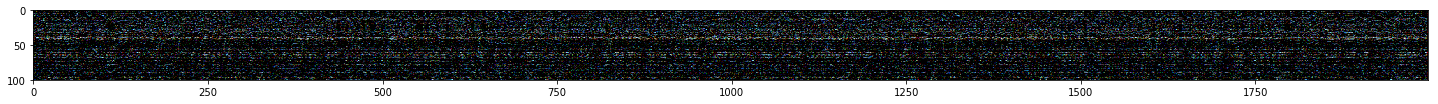

In [201]:
print(np.all(kmer_img[-2,:,2]==0))

import skimage.io

# test written images
plt.figure(figsize=(25,10))
im = skimage.io.imread(im_savedir +'0/0.tif')
im.shape
plt.imshow(np.transpose(im, axes = (1,0,2)))

In [188]:
    
# print(l)

# im = plt.imread(im_savedir +'/0/0.bmp')
# im.shape
# v1 = mk_model.vector('GAG')
# v2 = mk_model.vector(l[:3])

# i = 0
# v3mer_i = im[104,:,1]
# #any(v3mer_i != v2)
# v3mer_i

# np.any(im[:,:,2]!=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


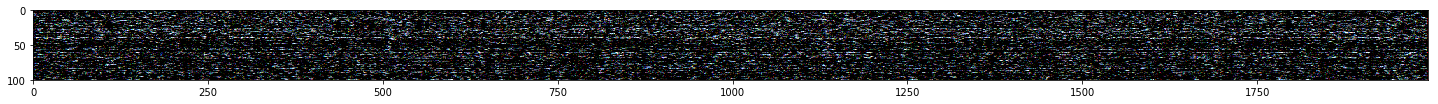

In [65]:
# # verify one-hot encoding correctness
# import glob

# print("unique labels:", unique_labels)

# for label in sorted(unique_labels):
#     im_files = glob.glob(f'{im_savedir}/{label}/*.bmp')
#     print("images in class",label,":", len(imfiles))
#     for im_file in im_files:
#         img = plt.imread(im_file)
#         if len(img)!=1998:
#             print("sequence length incorrect:",im_file)
#         if(np.any(np.sum(img,  axis = 1) !=1) ):
#             print("onehot_encoding error:",im_file)
#             print(not np.any(np.sum(img,  axis = 1) !=1) )
#             break
            
# #         for row in img:    
# #             if sum(row)!=1:
# #                 print(im_file)
# #                 break

unique labels: ['1', '0']
images in class 0 : 18487
images in class 1 : 18487


In [66]:
# # test written images
# im = plt.imread('/disks/data/paper_projects/DeepCNC/data/imdata//0/17236.bmp')
# im.shape
# plt.plot(np.sum(im,  axis = 1))
# #plt.imshow(im)
# np.any(np.sum(im,  axis = 1) !=1)
# np.any(np.sum(im,  axis = 1) !=1)

In [104]:
    # PIL
    #img = Image.fromarray(a.astype(np.uint8))
    #img.save(save_dir+f'/{labels[k]}/{k}.bmp', cmap=cm.gray)  
    # imageio
    #imageio.imwrite(save_dir+f'/{labels[k]}/{k}.png', a)            
    # matplotlib
    #plt.imsave(save_dir+f'/{labels[k]}/{k}.png', a, cmap=cm.gray)                    
    #plt.imsave(save_dir+f'/{labels[k]}/{k}.png', a)                    

    # scipy
    # works; saves as 3-channel png, but gives future deprecation warning and truncated values to [0,1]
    #scipy.misc.toimage(a).save(save_dir+f'/{labels[k]}/{k}.png')

    #np.save(save_dir+f'/{labels[k]}/{k}.npy', a)

    #scipy.misc.imsave(save_dir+f'/{k}.bmp', a)                        
    #np.save(save_dir+f'/{k}.npy', a)
    #plt.imsave(save_dir+f'/{k}.png', a, cmap=cm.gray)                    


In [8]:
# def generate_kmers(alphabet, k):
  
#     def compute_kmers(letters, pos, k, kmer_lst, kmer_prefix):
#         if pos < k:
#             for l in letters:
#                 compute_kmers(letters, pos + 1, k, kmer_lst, kmer_prefix + l)
#         else:
#             for l in letters:
#                 kmer_lst.append(kmer_prefix+ l)

#     kmers = []

#     kmer_prefix = ""
#     kmer_start_pos = 1

#     compute_kmers(alphabet, kmer_start_pos , k, kmers, kmer_prefix)        

#     return kmers


# alphabet = ['A', 'C', 'G', 'T']
# k = 5
# kmers = generate_kmers(alphabet, k )
# print("Number of generated ",k,"-mers:",len(kmers))
# # print(kmers)

# kmer_to_idx = dict(zip(kmers, range(len(kmers))))

Number of generated  5 -mers: 1024


In [ ]:
# from sys import getsizeof


# integer_encoder = LabelEncoder()
# integer_encoder.fit(kmers)
# #print("classes: " ,list(integer_encoder.classes_))


# def seq_to_kmers(sequence, k, is_overlapping = True, stride = 1):
  
#   start_idx = 0
#   end_idx = len(sequence)
#   scan_end = start_idx + k

#   kmers = []
  
#   while(scan_end <= end_idx):
#     kmer = sequence[start_idx : scan_end]
#     kmers.append(kmer)
#     if(not is_overlapping):
#       start_idx += k      
#       scan_end +=k        
#     else:
#       start_idx += stride      
#       scan_end +=stride        

#   return kmers

# #print(seq_to_kmers("ACTGAT", 3, True))


# is_overlapping = True

# one_hot_encoder = OneHotEncoder(categories=[range(len(kmers))])
# input_features = []
# myBuffer = ''
# count =1;

# for sequence in sequences:
#   kmers_in_sequence = seq_to_kmers(sequence, 3, is_overlapping)
#   integer_encoded = integer_encoder.transform(kmers_in_sequence)
#   integer_encoded = np.array(integer_encoded).reshape(-1, 1)
#   one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
#   #input_features.append(one_hot_encoded.toarray())
#   # myBuffer += ("Seq no:" + str(count) + "  len: " + str(len(sequence))  + " array len: " + str( len(one_hot_encoded.toarray()))  + "\n" )
#   count = count + 1
#   if count%(len(sequences)//10) ==0:
#     print(count,"/",len(sequences),sep="")
#     print(getsizeof(input_features))  
  
# print( "Encoding of input DONE")   



  

    


In [ ]:
# print(len(kmers_in_sequence))
# print(one_hot_encoded.shape)
# print(one_hot_encoded[0])
# # print(integer_encoded[0:5])
# # print(kmers_in_sequence[0:5])
# # print(sequence[:10])
# # sorted_kmers = list(sorted(kmers))
# # print(sorted_kmers[32])

# # print()

# # integer_encoder_nucleotides = LabelEncoder()
# # integer_encoder_nucleotides.fit(alphabet)
# # lst = list(sequence)
# # integer_encoded_dna = integer_encoder_nucleotides.transform(lst)
# # print(integer_encoded_dna[:5])
# # print(lst[:5])
# # print(sorted(alphabet))

In [ ]:
# integer_encoder = LabelEncoder()
# integer_encoder.fit(alphabet)
# print("classes: " ,list(integer_encoder.classes_))


In [ ]:


# ####################  Encode Input Sequence ##############
# one_hot_encoder = OneHotEncoder(categories=[range(len(kmers))])
# input_features = []
# myBuffer = ''
# count =1;
# for sequence in sequences:
#     integer_encoded = integer_encoder.transform(list(sequence))
#     integer_encoded = np.array(integer_encoded).reshape(-1, 1)
#     one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
#     input_features.append(one_hot_encoded.toarray())
#     # myBuffer += ("Seq no:" + str(count) + "  len: " + str(len(sequence))  + " array len: " + str( len(one_hot_encoded.toarray()))  + "\n" )
#     count = count + 1

# print( "Encoding of input DONE")   
    


array([1, 1])

In [96]:

# ------------------------------------------------------------------------------------------------------------------------------------------
# # normalizing a numpy array to [0,1] and retaining the parameters for de-normalization
# ------------------------------------------------------------------------------------------------------------------------------------------


# sample data
##a = np.random.random(size=(30, 20,3))



# # compute channelwise minimum of the unmodified data
# min_per_ch = np.min(a, axis = (0,1))

# print(min_per_ch) # inspect chnnalewise minimum of the unmodified data

# # zero-align the data by subtracting channelwise minimum
# subd = a - min_per_ch[np.newaxis,np.newaxis,:]

# # find the channelwise minimum and maximum of the zero-aligned data to verify the correctness of zero-alignmed and apply normalization
# min_per_ch_subd = np.min(subd, axis = (0,1))
# max_per_ch_subd = np.max(subd, axis = (0,1))

# print(min_per_ch_subd) # verify that the channelwise minimum of the zero-aligned data is 0 for every channel

# normed = subd/max_per_ch_subd[np.newaxis, np.newaxis, :]  # normalize to channelwise maximum of 1 

# # find the channelwise minimum and maximum of the normalized data to verify the correctness of normalization
# min_per_ch_normed = np.min(normed, axis = (0,1))
# max_per_ch_normed = np.max(normed, axis = (0,1))

# print(min_per_ch_normed) # verify that the channelwise minimum of the normalized data is 0 for every channel

# print(max_per_ch_normed) # verify that the channelwise maximum of the normalized data is 1 for every channel

# # reconstructing data from normalized data, channelwise_max and channelwise_min (order of operation is important)
# recon_a = normed*max_per_ch_subd[np.newaxis, np.newaxis, :]+min_per_ch[np.newaxis,np.newaxis,:] 
# np.any(a!=recon_a)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-13.152730968984887
11.033228884968748


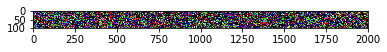

In [50]:
import numpy as np
from matplotlib import pyplot as plt
import skimage.io


ar = np.ones((50,50), dtype=np.uint16)
ar = ar * np.iinfo(np.uint16).max

img = (np.random.randn(2000,100, 3)-0.5)*2.4
plt.imshow(np.transpose(img, axes = (1,0,2)))

print(np.min(img))
print(np.max(img))
#skimage.io.imsave('img.tiff', img, 'tifffile')
skimage.io.imsave('img.tif', img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


float64
(2000, 100, 3)
-13.152730968984887
11.033228884968748
True


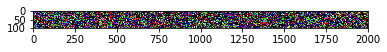

In [51]:
#im = skimage.io.imread('img.tiff', plugin='tifffile')
im = skimage.io.imread('img.tif')

print(im.dtype)
print(im.shape)
print(np.min(im))
print(np.max(im))
print(np.all(np.equal(img, im)))
plt.imshow(np.transpose(im, axes = (1,0,2)))

In [23]:
# from libtiff import TIFF
# tiff = TIFF.open('img.tiff', mode='w')
# tiff.write_image(img)
# tiff.close()
# img.shape



In [19]:
# from libtiff import TIFF

# tiff_img = TIFF.open('img.tiff', mode='r')
# img2 = tiff_img.read_image()
# tiff_img.close()
# print(img2.dtype)
# print(np.min(img2))
# print(np.max(img2))
# print(img2.shape)

float64
-8.216939567301234
5.092041367431963
(200, 3)


In [17]:
# img_tiff.shape

(200, 3)

float64
(200, 200, 3)
8.951101382005163
-11.982043715674488


True